# 📈📉📊프로젝트 : 주식 예측에 도전해 보자

이번 프로젝트로 시계열 예측 모델을 만들어보겠습니다. 
1. 먼저 데이터를 불러오겠습니다.
2. 다음에 시계열 예측이 가능한 데이터인지 Stationarity를 확인 하겠습니다. 
3. ARIMA 모수를 acf, pacf plot을 통해 선택하겠습니다. 
4. 모델 예측 후 metric 검증하겠습니다. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## STEP 1 : 시계열 데이터 준비

- 데이터 불러오기
- Close 기준 예측

In [2]:
df = pd.read_csv('/Users/seungyonglee/Desktop/Life3/aiffel/project/data/005930.KS.csv', index_col ='Date',parse_dates=True)
cdf = df['Close']

## STEP 2 :  시계열 안정성의 정성적 분석

- 시계열 데이터 안정적 수준 그래프로 확인(평균, 표준편차) 비교

In [3]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

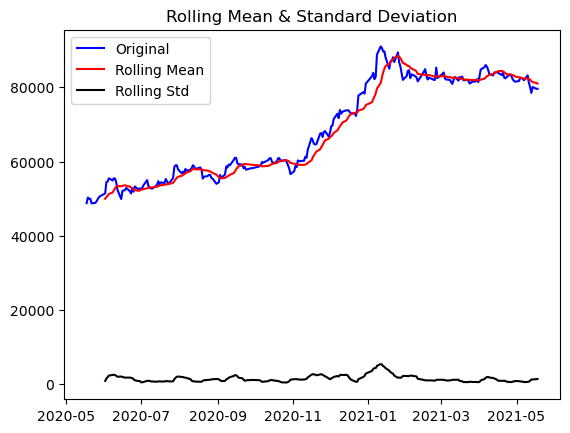

In [4]:
plot_rolling_statistics(cdf)

### 결측치 확인

In [5]:
cdf[cdf.isna()]

Series([], Name: Close, dtype: float64)

In [6]:
from statsmodels.tsa.stattools import adfuller

In [7]:
def adf_test(timeseries) :
    dftest = adfuller(timeseries, autolag ='AIC')
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

p-value가 0.05 이하가 아님으로 안정적이라 말할 수 없음

In [8]:
adf_test(cdf)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


### 로그 변환

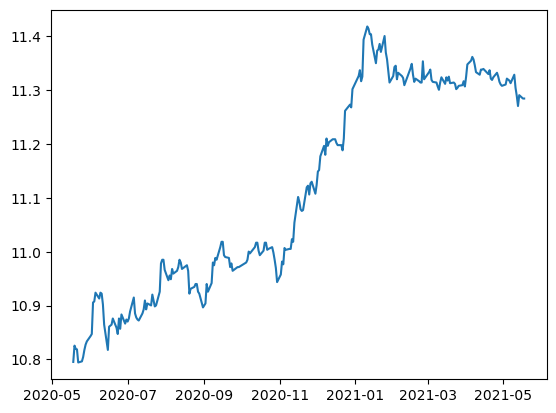

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [9]:
cdf_log = np.log(cdf)
plt.plot(cdf_log)
plt.show()
adf_test(cdf_log)

## Decomposition으로 residual 안정화 가능 확인

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

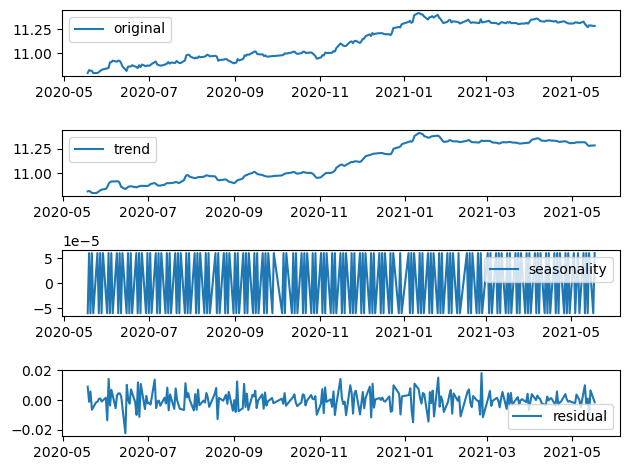

In [11]:
decomposition = seasonal_decompose(cdf_log, period=2)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(cdf_log, label='original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='residual')
plt.legend(loc='best')


plt.tight_layout()

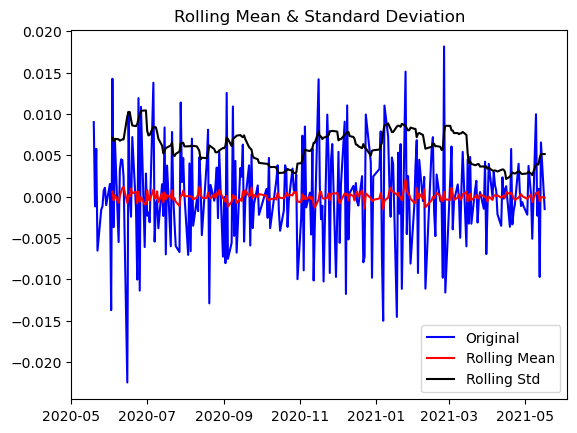

In [12]:
plot_rolling_statistics(residual)

P-value가 작아지는 것을 확인. 
안정적 형태의 시계열 데이터로 변환 됨

In [13]:
residual.dropna(inplace=True)
adf_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.029236e+01
p-value                        3.542768e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


## ARIMA 모델의 모수 p,q,d

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

- 아래 표 기준으로 p,q,d 모수 선택
- adf, padf 살펴본 결과 0,1,2 가 적절한 모수로 확인

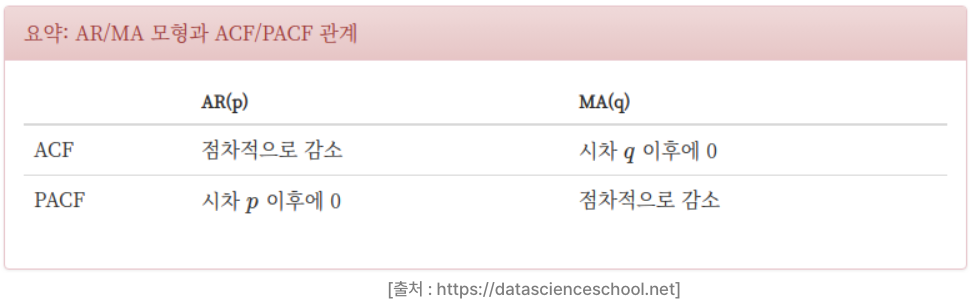

/Users/seungyonglee/miniconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


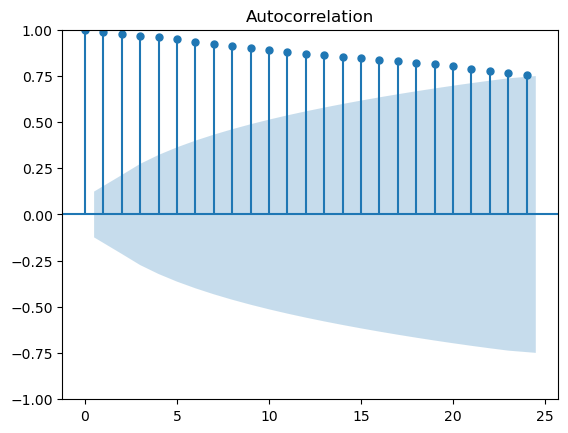

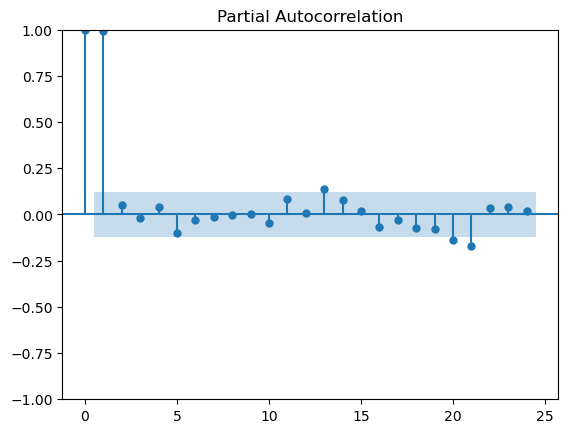

In [15]:
plot_acf(cdf_log)
plot_pacf(cdf_log)
plt.show()

# STEP 3 : 학습, 테스트 데이터셋 생성

- train, test 9:1 비율로 split

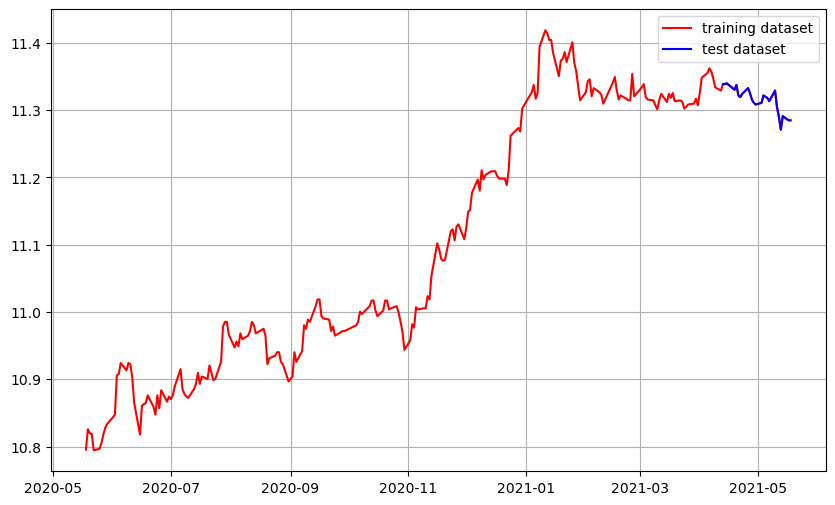

In [16]:
train, test = cdf_log[:int(len(cdf_log)*0.9)], cdf_log[int(len(cdf_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(cdf_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test, c='b', label='test dataset')
plt.legend()

## ARIMA 모델 훈련과 추론

In [17]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

model =ARIMA(train, order=(0,1,2))

fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 583.497
Date:                Tue, 22 Nov 2022   AIC                          -1160.994
Time:                        00:02:18   BIC                          -1150.759
Sample:                             0   HQIC                         -1156.863
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0334      0.062      0.541      0.588      -0.088       0.154
ma.L2         -0.0073      0.076     -0.097      0.923      -0.156       0.142
sigma2         0.0003   2.47e-05     12.942      0.0

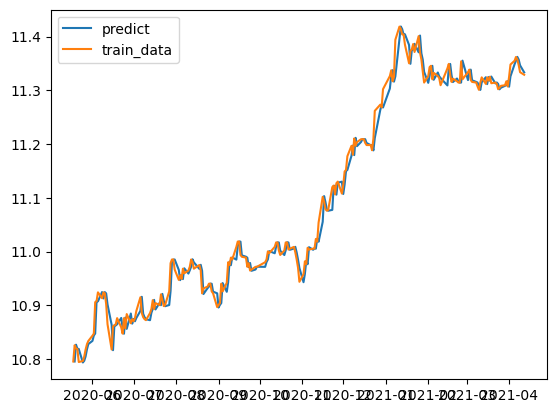

In [18]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train, label='train_data')
plt.legend()

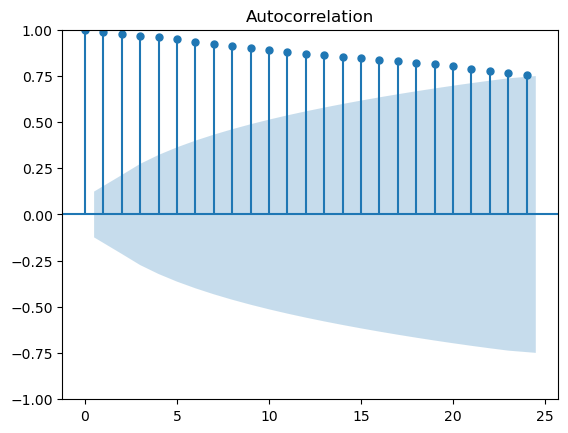

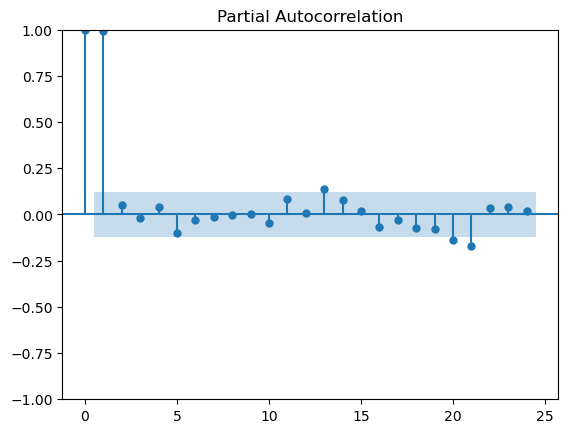

In [19]:
plot_acf(cdf_log)
plot_pacf(cdf_log)
plt.show()

- 위에서 언급한바와 같이 p d q 설정
    - adf는 gradual하게 떨어지고
    - pacf는 급격하게 2번째 정도에서 0으로 떨어진다
  

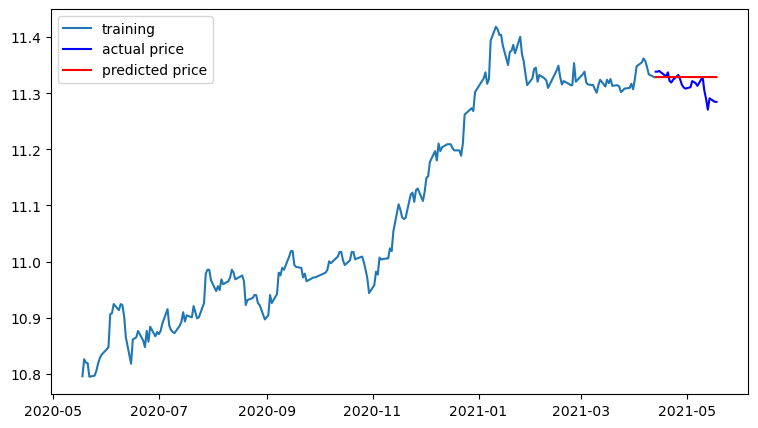

In [20]:
model = ARIMA(train, order=(0, 1, 2))  # p값을 14으로 테스트
fitted_m = model.fit() 

fc= fitted_m.forecast(len(test), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index= test.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

# STEP 4 : ARIMA 모델 테스트

- 결과는 MAPE 기준 1.74%로 나옴

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test))/np.abs(np.exp(test)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3505836.3262073887
MAE:  1407.4417942677246
RMSE:  1872.387867458927
MAPE: 1.74%


# STEP 5 : 다른 주식 종목 예측해 보기

### 모듈화

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


def adf_test(timeseries) :
    dftest = adfuller(timeseries, autolag ='AIC')
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


def plot_acf_pacf(timeseries) :
    plot_acf(timeseries)
    plot_pacf(timeseries)
    plt.show()


def timeseries_adf_padf(timeseries) :

    #plot data of timeseries, mean, std to check stationarity
    plot_rolling_statistics(timeseries)

    #print adf test results
    print()
    print('adf test of timeseries')
    adf_test(timeseries)

    #plot adf and padf
    plot_acf_pacf(timeseries)


def timeseries_decomposition(timeseries, period=12) :
    decomposition = seasonal_decompose(timeseries, period=period)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(timeseries, label='original')
    plt.legend(loc='best')

    plt.subplot(412)
    plt.plot(trend, label='trend')
    plt.legend(loc='best')

    plt.subplot(413)
    plt.plot(seasonal, label='seasonality')
    plt.legend(loc='best')

    plt.subplot(414)
    plt.plot(residual, label='residual')
    plt.legend(loc='best')


    plt.tight_layout()
    plt.show()


    #check stationarity of residual
    print()
    residual.dropna(inplace=True)
    adf_test(residual)


def timeseries_check_diff(timeseries) :

    diff_1 = timeseries.diff(periods=1).iloc[1:]

    diff_1.plot(title='diff1')

    adf_test(diff_1)
    
    plt.show()

    diff_2 = diff_1.diff(periods=1).iloc[1:]

    diff_2.plot(title='diff2')

    adf_test(diff_2)
    
    plt.show()

def timeseries_train_test_arima_mape(timeseries, p, d, q) :

    train, test = timeseries[:int(len(timeseries)*0.9)], timeseries[int(len(timeseries)*0.9):]

    model =ARIMA(train, order=(p,d,q))

    fitted_m = model.fit()
    fc = fitted_m.forecast(len(test), alpha=0.05)  # 95% conf
    fc = np.array(fc)
    fc_series = pd.Series(fc, index= test.index)
    plt.figure(figsize=(9,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.legend()
    plt.show()

    print(fitted_m.summary())

    mse = mean_squared_error(np.exp(test), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test), np.exp(fc)))
    print('RMSE: ', rmse)
    
    mape = np.mean(np.abs(np.exp(fc) - np.exp(test))/np.abs(np.exp(test)))
    print('MAPE: {:.2f}%'.format(mape*100))
    

# 네이버 

In [23]:
path = '/Users/seungyonglee/Desktop/Life3/aiffel/project/data/035420.KS.csv'
df = pd.read_csv(path,usecols=['Close','Date'], index_col = 'Date', parse_dates =True)

In [24]:
timeseries = np.log(df['Close'])

In [25]:
timeseries.isnull().sum()

0

P-value 확인 결과 0.05보다 커, 안정적이지 않은 형태임

acf, pacf 결과 0,1,2 order가 적절한 모수로 보임

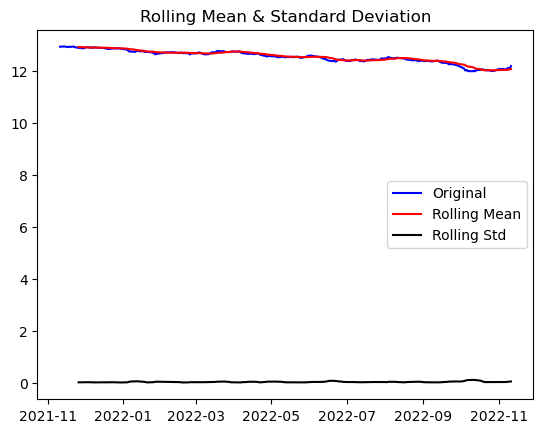


adf test of timeseries
Results of Dickey-Fuller Test:
Test Statistic                  -0.858860
p-value                          0.801219
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


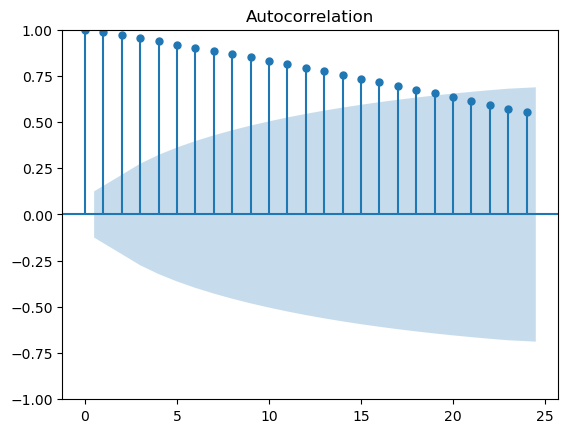

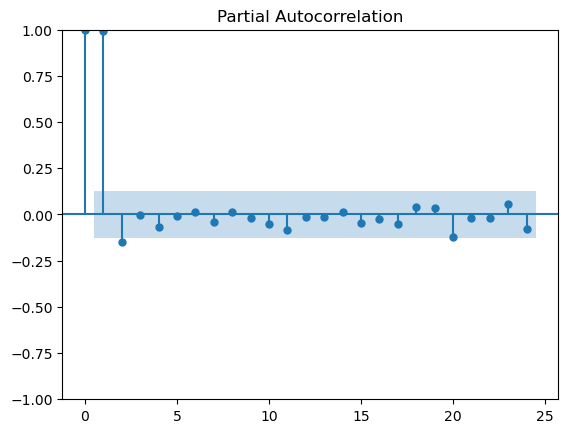

In [26]:
timeseries_adf_padf(timeseries)

- Differencing 후 p-value 유의미한 것으로 나타남

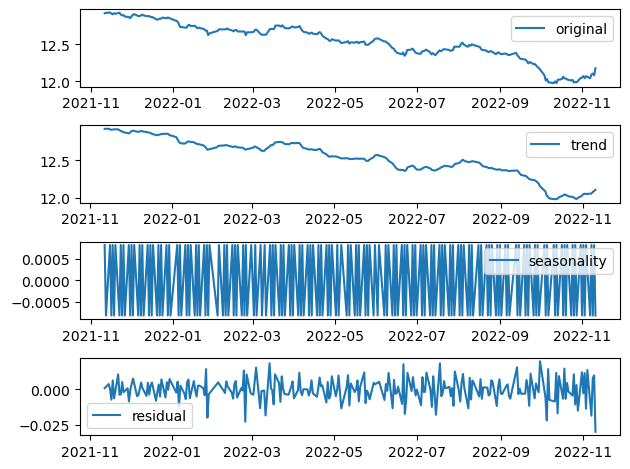


Results of Dickey-Fuller Test:
Test Statistic                -8.292135e+00
p-value                        4.233726e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


In [27]:
timeseries_decomposition(timeseries, period=2)

differencing으로 안정적 형태 변환 가능한것으로 나타남

Results of Dickey-Fuller Test:
Test Statistic                -7.328588e+00
p-value                        1.143604e-10
#Lags Used                     3.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


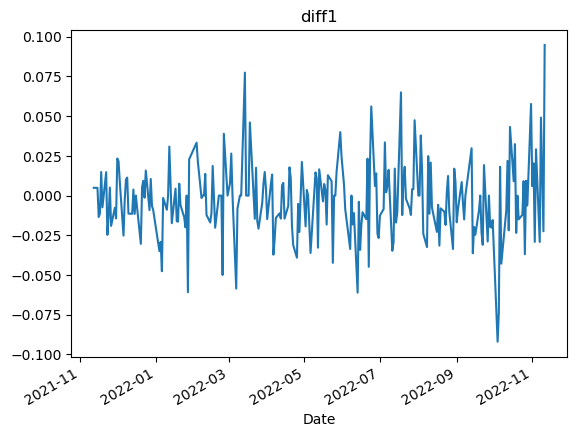

Results of Dickey-Fuller Test:
Test Statistic                -8.248863e+00
p-value                        5.459537e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


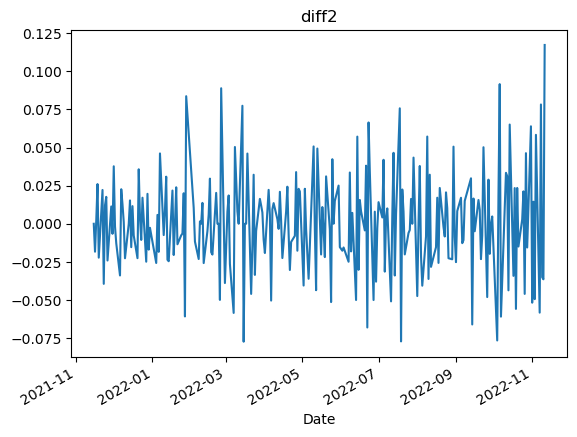

In [28]:
timeseries_check_diff(timeseries)

예측 모델 성과 metric으로 MAPE 기준 3.45%로 나타남

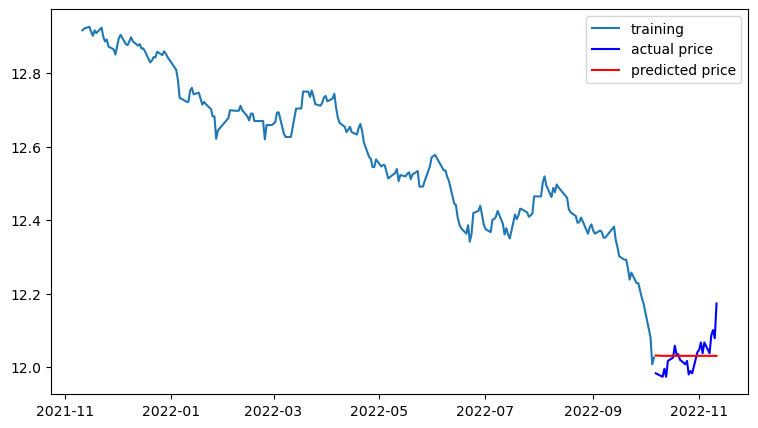

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 524.298
Date:                Tue, 22 Nov 2022   AIC                          -1042.596
Time:                        00:02:29   BIC                          -1032.415
Sample:                             0   HQIC                         -1038.484
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1339      0.060      2.223      0.026       0.016       0.252
ma.L2         -0.0439      0.070     -0.626      0.532      -0.181       0.094
sigma2         0.0005   3.58e-05     13.907      0.0

In [29]:
timeseries_train_test_arima_mape(timeseries, p=0, d=1, q=2)

## META

In [30]:
path = '/Users/seungyonglee/Desktop/Life3/aiffel/project/data/META.csv'
df = pd.read_csv(path,usecols=['Close','Date'], index_col = 'Date', parse_dates =True)

In [31]:
timeseries = np.log(df['Close'])

In [32]:
timeseries.isnull().sum()

0

P-value 확인 결과 0.05보다 커, 안정적이지 않은 형태임

acf, pacf 결과 0,1,2 order가 적절한 모수로 보임

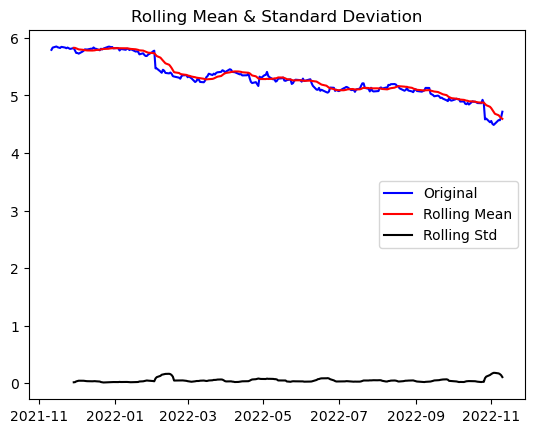


adf test of timeseries
Results of Dickey-Fuller Test:
Test Statistic                  -0.812226
p-value                          0.815504
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


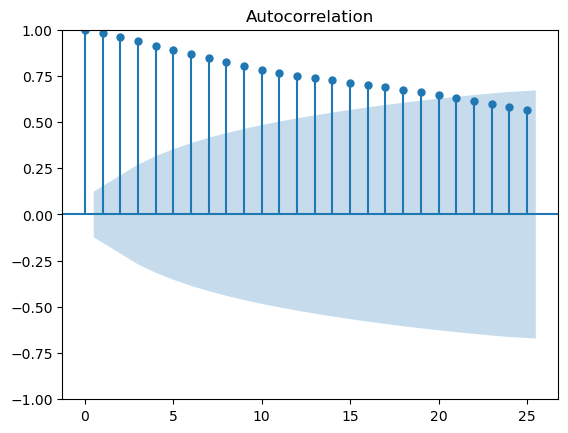

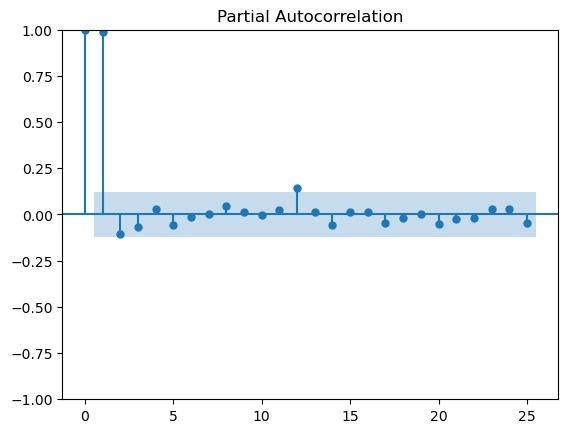

In [33]:
timeseries_adf_padf(timeseries)

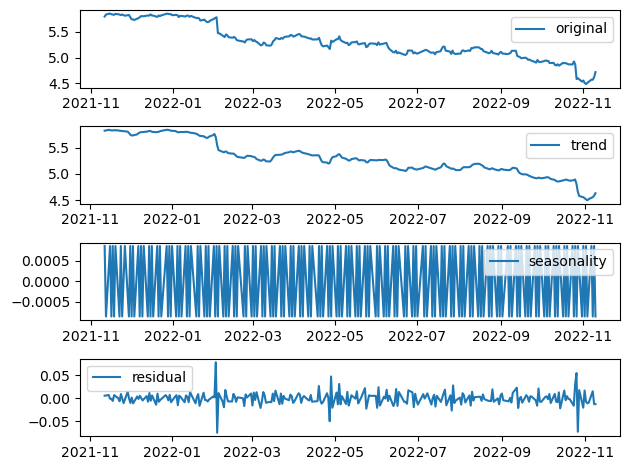


Results of Dickey-Fuller Test:
Test Statistic                -8.110191e+00
p-value                        1.231791e-12
#Lags Used                     1.000000e+01
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


In [34]:
timeseries_decomposition(timeseries, period=2)

Results of Dickey-Fuller Test:
Test Statistic                -1.586661e+01
p-value                        9.082400e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


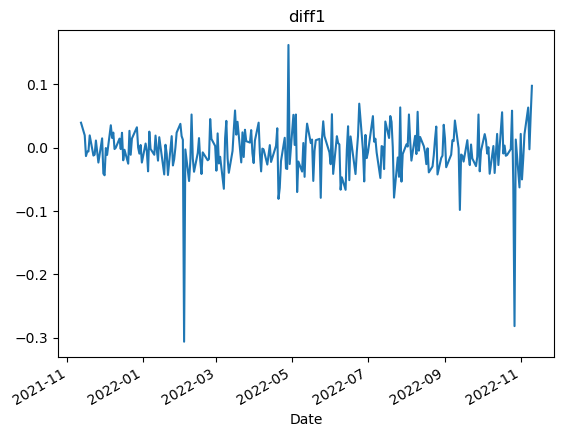

Results of Dickey-Fuller Test:
Test Statistic                -8.117535e+00
p-value                        1.179896e-12
#Lags Used                     1.000000e+01
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


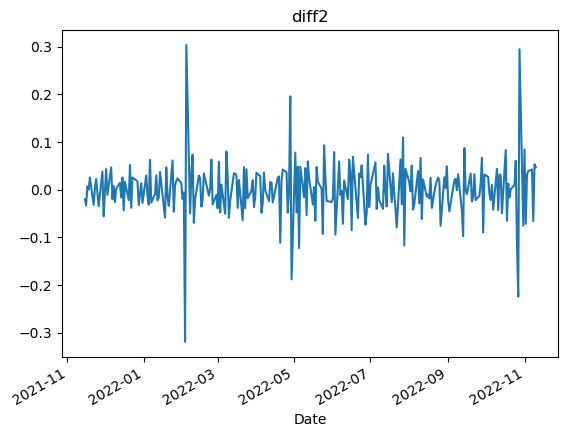

In [35]:
timeseries_check_diff(timeseries)

최근 데이터에서 급격하게 떨어지는 추세로 보여 d =2로 변경하여 예측모델 모수 설정
- 보다 안정적인 데이터로 MAPE 점수 개선

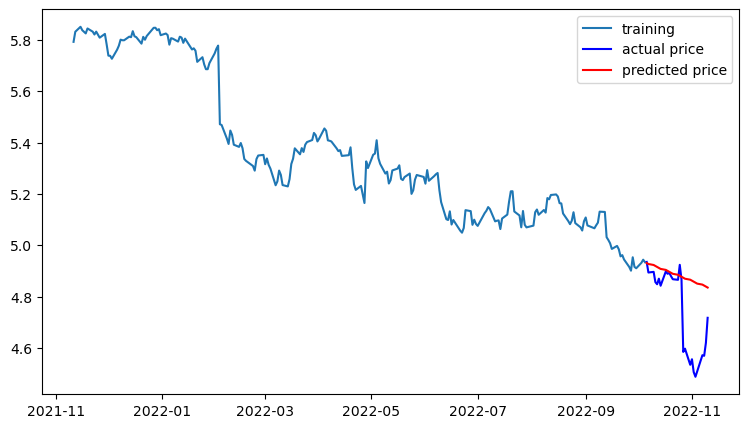

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(0, 2, 2)   Log Likelihood                 413.632
Date:                Tue, 22 Nov 2022   AIC                           -821.264
Time:                        00:02:35   BIC                           -811.029
Sample:                             0   HQIC                          -817.133
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0436      7.485     -0.139      0.889     -15.714      13.626
ma.L2          0.0437      0.319      0.137      0.891      -0.582       0.670
sigma2         0.0014      0.011      0.133      0.8

In [36]:
timeseries_train_test_arima_mape(timeseries, p=0, d=2, q=2)

## Zoom

In [37]:
path ='/Users/seungyonglee/Desktop/Life3/aiffel/project/data/ZM.csv'
df = pd.read_csv(path, usecols=['Close','Date'], index_col = 'Date', parse_dates = True)

In [38]:
timeseries = np.log(df['Close'])

In [39]:
timeseries.isnull().sum()

0

P-value 확인 결과 0.05보다 커, 안정적이지 않은 형태임

acf, pacf 결과 0,1,2 order가 적절한 모수로 보임

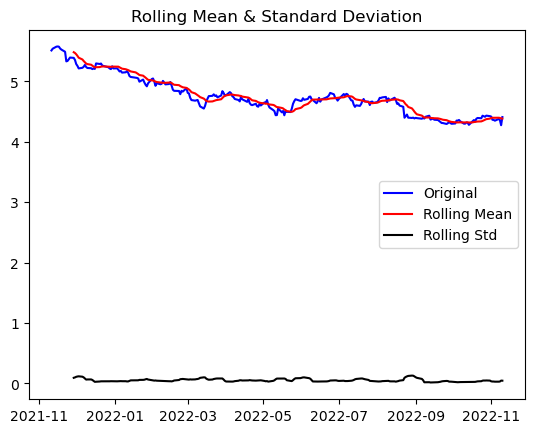


adf test of timeseries
Results of Dickey-Fuller Test:
Test Statistic                  -2.190515
p-value                          0.209706
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


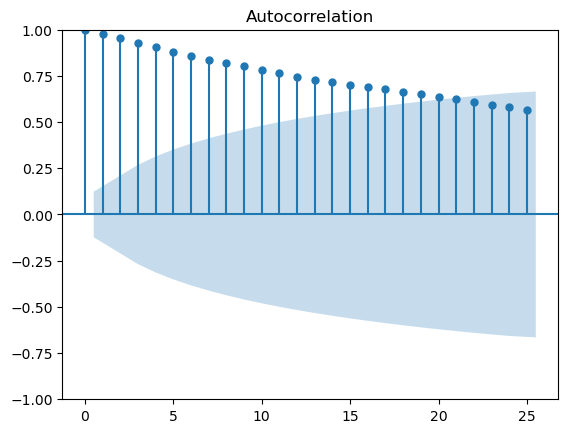

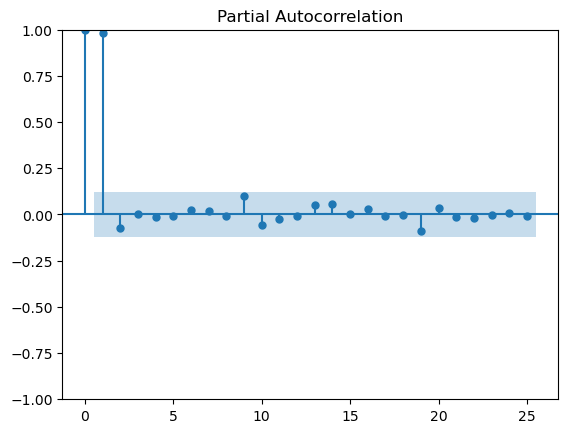

In [40]:
timeseries_adf_padf(timeseries)

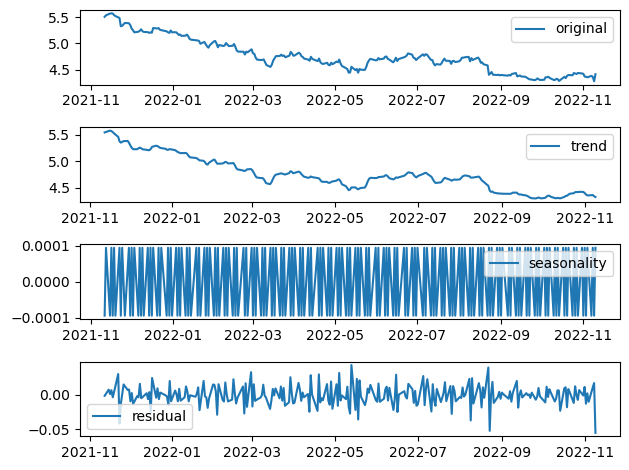


Results of Dickey-Fuller Test:
Test Statistic                -1.077422e+01
p-value                        2.342097e-19
#Lags Used                     7.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64


In [41]:
timeseries_decomposition(timeseries, period=2)

Results of Dickey-Fuller Test:
Test Statistic                -1.614866e+01
p-value                        4.594283e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


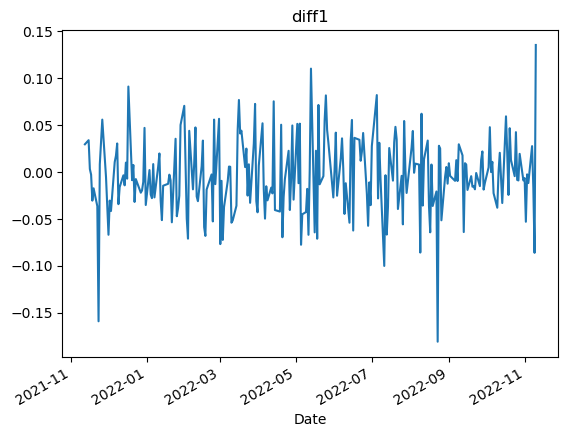

Results of Dickey-Fuller Test:
Test Statistic                -1.077349e+01
p-value                        2.351684e-19
#Lags Used                     7.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64


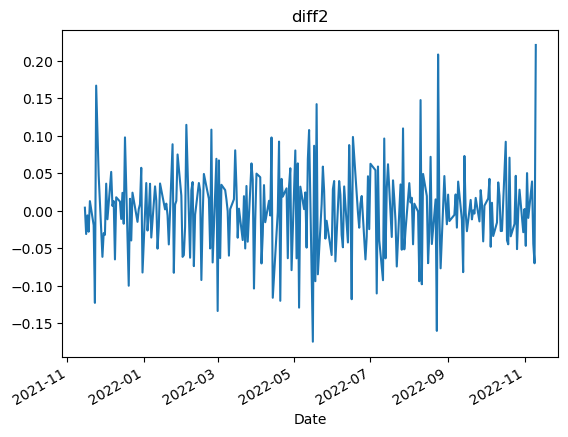

In [42]:
timeseries_check_diff(timeseries)

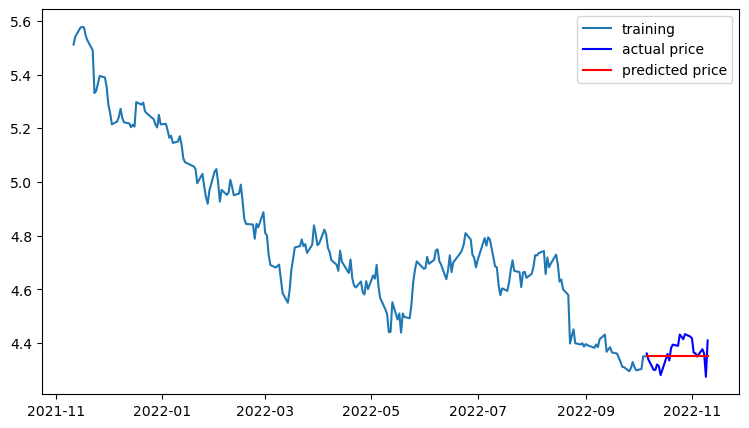

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 397.587
Date:                Tue, 22 Nov 2022   AIC                           -789.173
Time:                        00:02:43   BIC                           -778.925
Sample:                             0   HQIC                          -785.037
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0028      0.073     -0.038      0.969      -0.147       0.141
ma.L2         -0.0005      0.067     -0.007      0.994      -0.132       0.131
sigma2         0.0017      0.000     13.661      0.0

In [43]:
timeseries_train_test_arima_mape(timeseries, p=0, d=1, q=2)